# Visualizing the embedding of new biosamples into the coordinate space.
### How can we represent newly generated DNase-seq data alongside the original 733 biosamples, using NMF?
Based on 733 sample x 3.5+ million DHS presence/absence matrix

# 1. Import libraries & load decomposed matrices

In [1]:
from platform import python_version
print(python_version())

3.6.4


In [2]:
import sys
import numpy as np
import pandas as pd
import gzip 
import matplotlib.pyplot as plt

In [3]:
sys.path.append('..')
import OONMFhelpers
from OONMFhelpers import get_barsortorder
import OONMF

### Load in original decomposition based on 733 ENCODE biosamples and verify shape

In [4]:
original_decomp = OONMF.NMFobject(16)
original_decomp.matrix_input_name('../data/2018-06-08NC16_NNDSVD_Basis.npy', '../data/2018-06-08NC16_NNDSVD_Mixture.npy')
original_decomp.read_matrix_input(compressed=True)
original_decomp.normalize_matrices()
original_decomp.Basis.shape

(733, 16)

### Define color scheme

In [5]:
Comp_colors = ['#FFE500', '#FE8102', '#FF0000', '#07AF00', '#4C7D14', '#414613', '#05C1D9', '#0467FD', '#009588', '#BB2DD4', '#7A00FF', '#4A6876', '#08245B', '#B9461D', '#692108', '#C3C3C3']
neworder = np.array([16,10,7,11,2,12,1,8,4,15,14,5,9,6,3,13]).astype(int) - 1
Comp_colors = np.array(Comp_colors)[neworder]

### Obtain names of the ENCODE samples

In [6]:
sampnamePD = pd.read_table('../data/sampnams_733.txt', header=None, names=['LN', 'DS', 'type'])
sampnamePD['full_name'] = sampnamePD.LN + '-' + sampnamePD.DS + '-' + sampnamePD.type
fullnames = sampnamePD.full_name.values
len(fullnames)

733

# 2. Visualizing new data with the same embedding

### We consider 13 new whole-genome DNase-Seq datasets for Pancreatic Cancer Cell Lines

### Note: a different script performed the embedding operation. Here, we visualize the result of the embedding.

In [7]:
revised_decomp = OONMF.NMFobject(16)
revised_decomp.matrix_input_name('../data/2018-11-09PancSpecialNC16seed20.npy', '../data/2018-06-08NC16_NNDSVD_Mixture.npy')
revised_decomp.read_matrix_input(compressed=True)
revised_decomp.normalize_matrices()
revised_decomp.Basis.shape

(746, 16)

### Obtain loadings for the newly added biosamples only

In [8]:
revised_Basis_newonly = revised_decomp.Basis[733:]
revised_NormedBasis_newonly = revised_decomp.NormedBasis[733:]
revised_Basis_newonly.shape

(13, 16)

### Obtain biosamples in the original set of 733 biosamples that have similar characteristics -- i.e. are also pancreatic (cancer).
### This will aid in comparing the newly added biosamples to relevant existing ones

In [9]:
pancnames_cut = []
for name in fullnames:
    if 'PANC' in name:
        pancnames_cut.append(True)
    elif 'Pancreas' in name:
        pancnames_cut.append(True)        
    else:
        pancnames_cut.append(False)
        
pancnames_cut = np.array(pancnames_cut)
len(pancnames_cut[pancnames_cut])

3

### We also assign names to the newly added biosamples

In [10]:
finname = '../data/sampnams_pancreatic.txt'
f = open(finname, 'r')
dars = f.readlines()
pank_LN_ar = []
for line in dars:
    pank_LN_ar.append(line.strip())
f.close()

### Combine existing and newly added biosample names and sort according to majority component

In [11]:
allnames = fullnames.tolist() + pank_LN_ar
barsortorder = get_barsortorder(revised_decomp.Basis)

### Visualization including the newly added biosamples. Mostly looks like the existing one, which is good.

<Figure size 432x288 with 0 Axes>

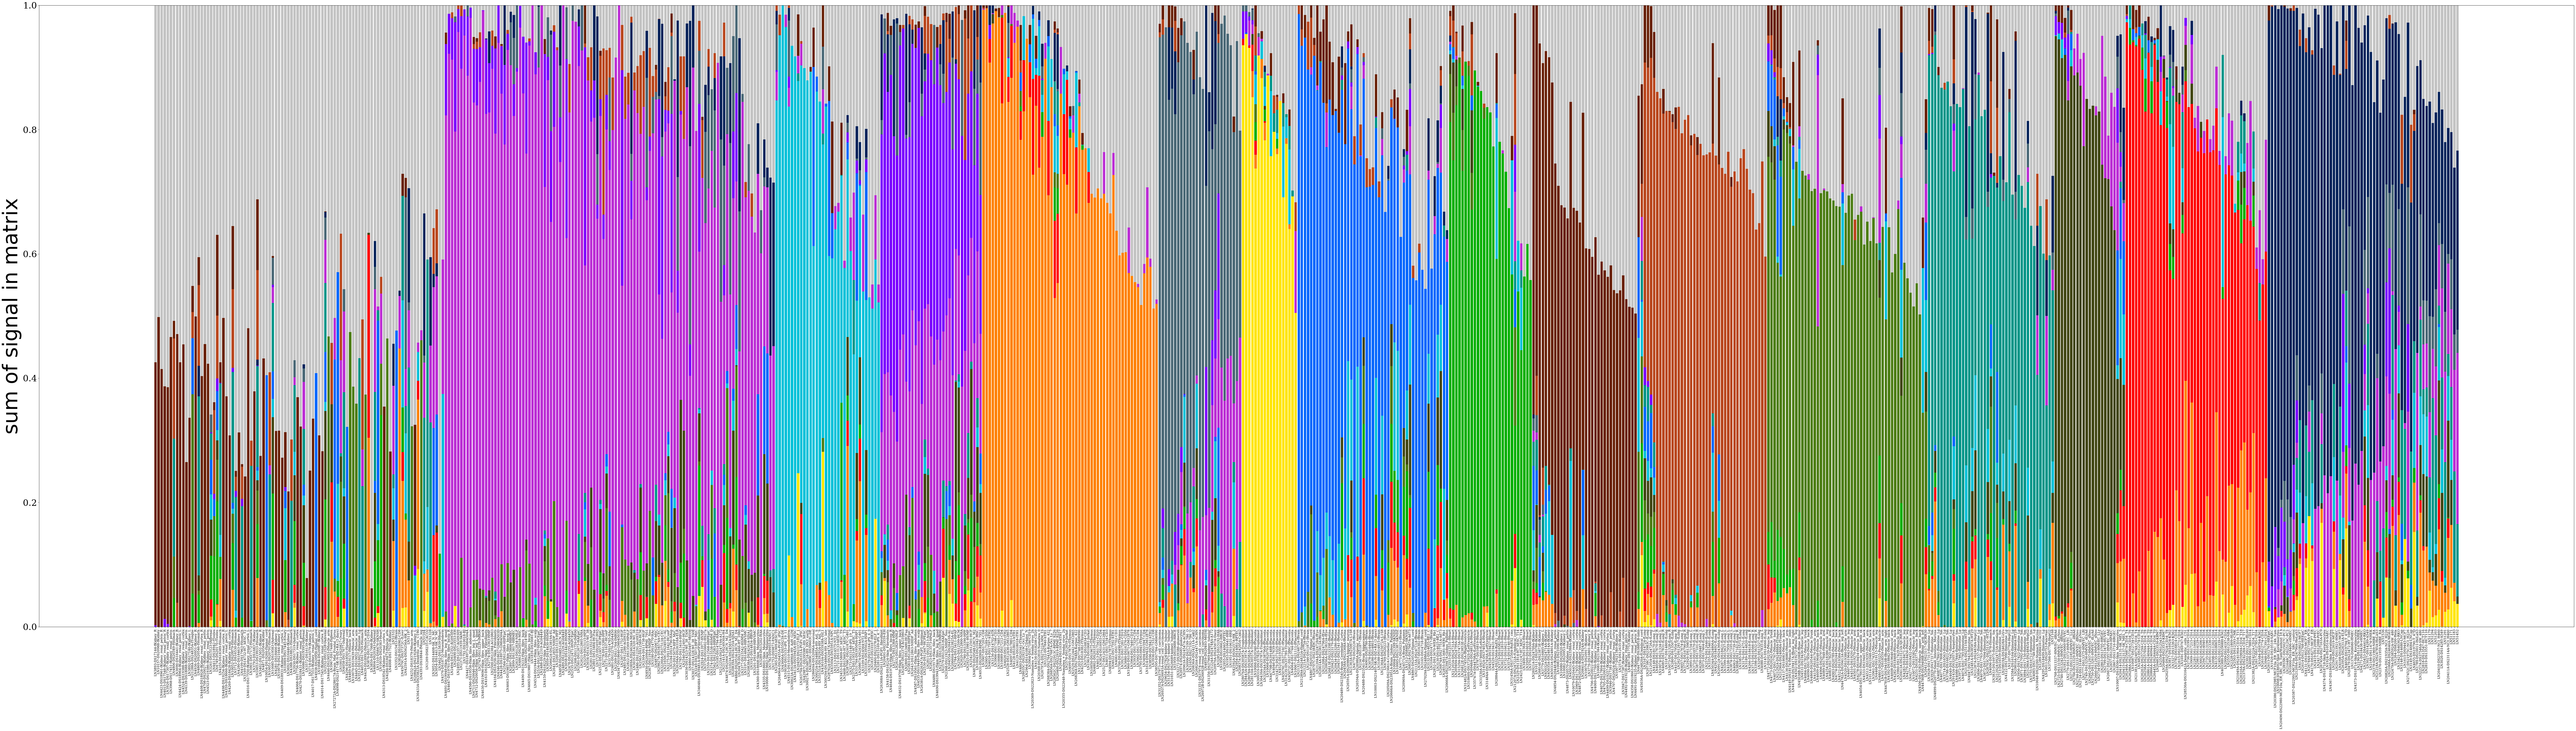

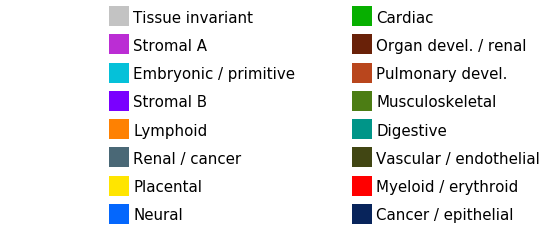

In [12]:
revised_decomp.make_stacked_bar_plot(746, revised_decomp.NormedBasis.T, '', names=np.array(allnames), official_order=True, barsortorder=barsortorder)
original_decomp.make_anatomy_key()

### We now visualize existing and new pancreatic cancer biosamples. The first 3 are from the existing biosamples.
#### These 3 are mostly a mixture of "Tissue invariant", "Stromal", "Cancer/epithelial" and "Digestive" NMF components. 
#### The newly added biosamples generally look similar to the existing ones.

In [13]:
old_new_panc = np.concatenate([original_decomp.NormedBasis[pancnames_cut],revised_NormedBasis_newonly ])
old_new_panc_names = np.array(fullnames[pancnames_cut]).tolist() + pank_LN_ar

<Figure size 432x288 with 0 Axes>

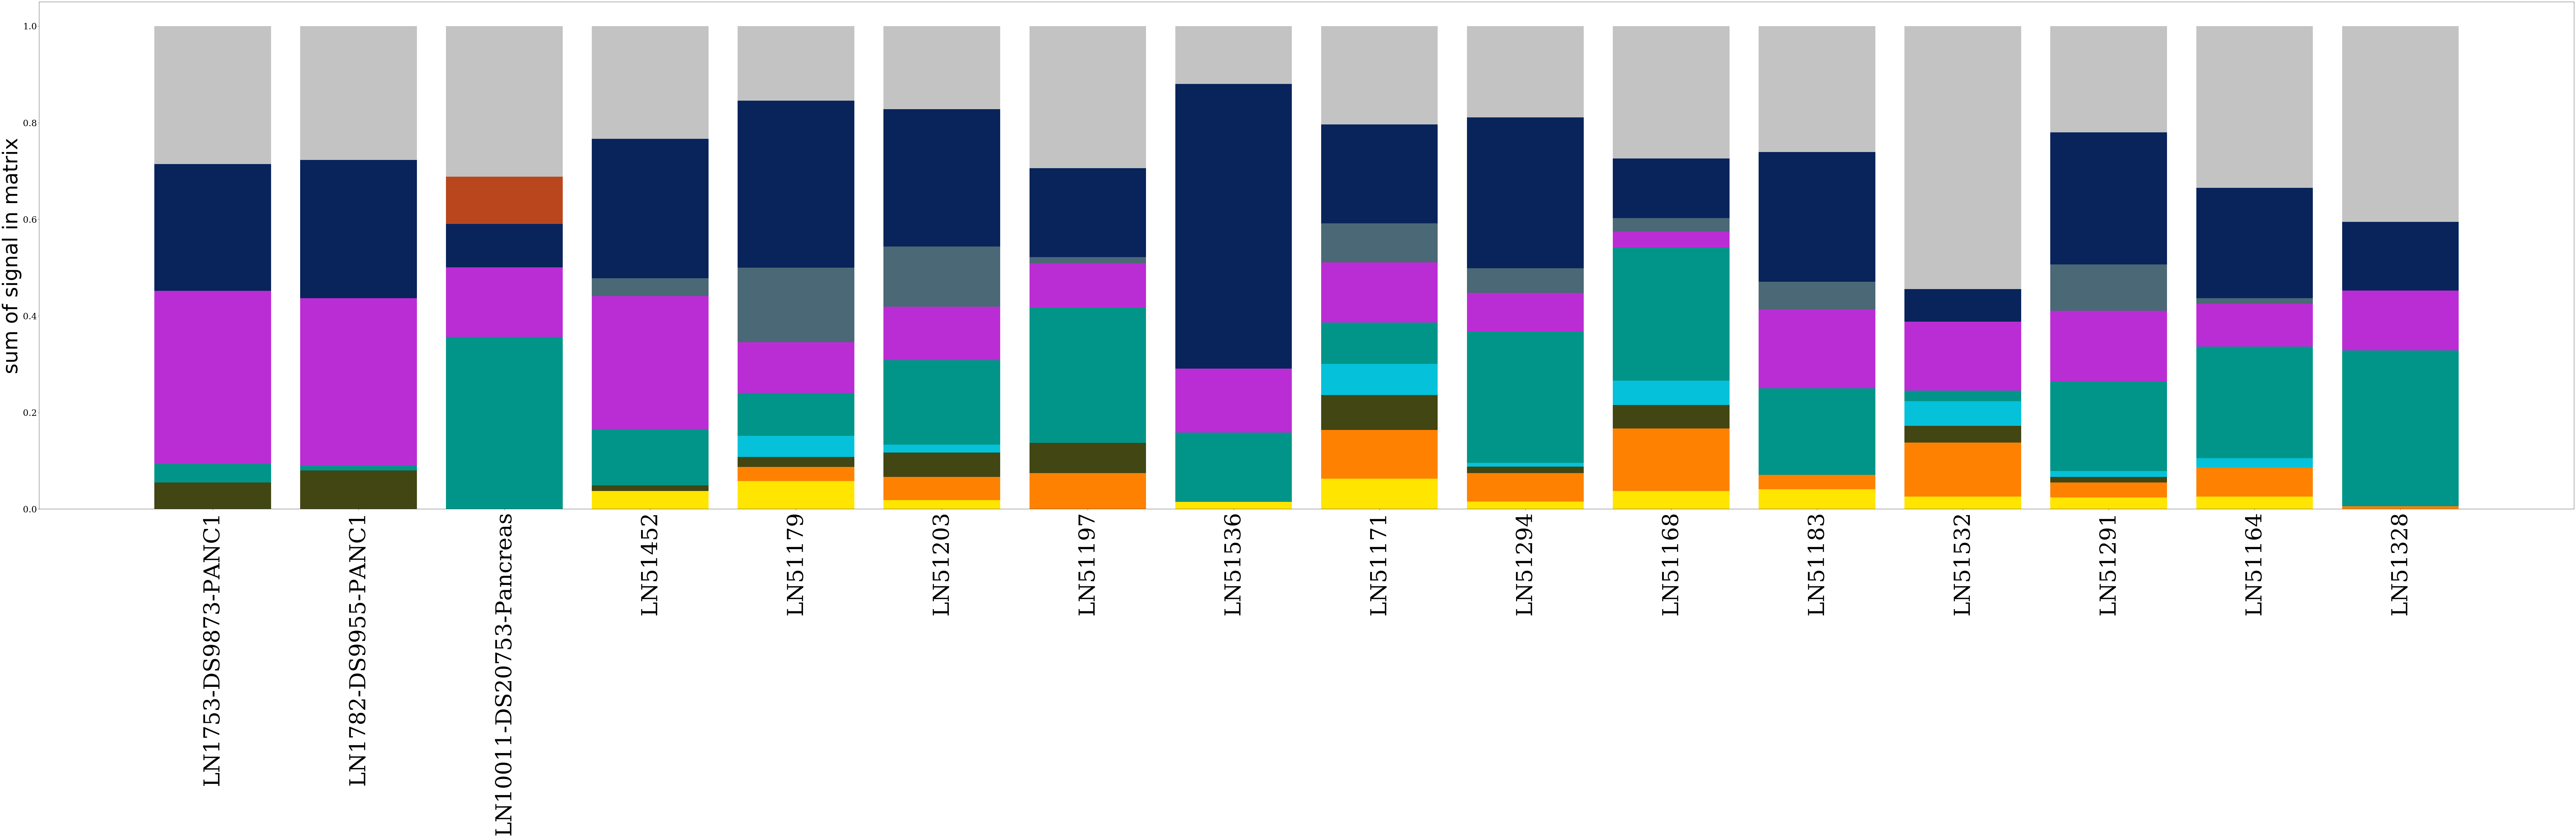

In [14]:
original_decomp.make_stacked_bar_plot(13+len(pancnames_cut[pancnames_cut]), old_new_panc.T, '', official_order=True, names=np.array(old_new_panc_names))

### We can see how samples relate to each other with a simple UMAP embedding. 

In [15]:
import umap
reducer = umap.UMAP(min_dist=0.5, n_neighbors=200, random_state=33)
embedding = reducer.fit_transform(original_decomp.Basis)
majcomp = np.argmax(original_decomp.Basis, axis=1)

<Figure size 432x288 with 0 Axes>

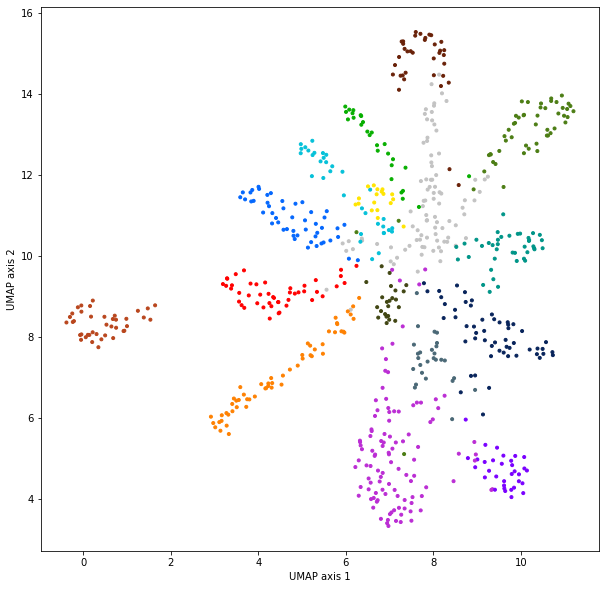

In [16]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], color=Comp_colors[majcomp], alpha=1, marker='.')
plt.ylabel('UMAP axis 2')
plt.xlabel('UMAP axis 1')
plt.show()

### And finally, we can see where the new samples lie in relation to the old samples
#### Stars indicate the newly added biosamples, and upside down triangles the existing 3 from the 733-biosample set.

In [17]:
newdata = reducer.transform(revised_Basis_newonly)
majcomp_new = np.argmax(revised_Basis_newonly, axis=1)

<Figure size 432x288 with 0 Axes>

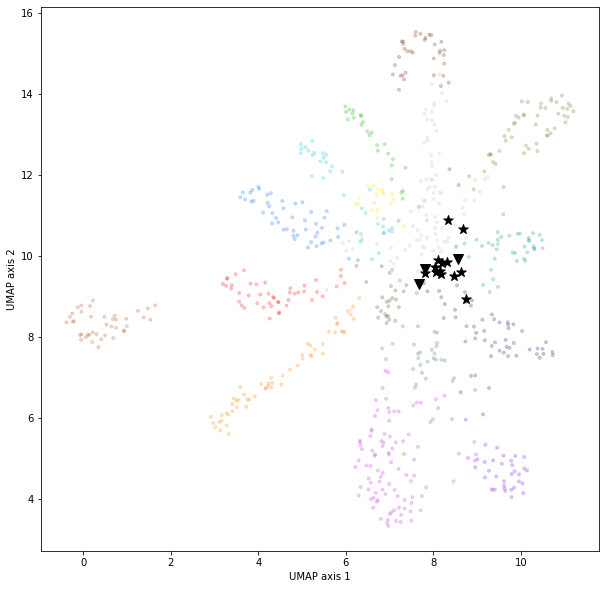

In [18]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], color=Comp_colors[majcomp], alpha=0.2, marker='.')
plt.scatter(newdata[:,0], newdata[:,1], color='black', alpha=1, marker='*', s=100)
plt.scatter(embedding[:,0][pancnames_cut], embedding[:,1][pancnames_cut], color='black', alpha=1, marker='v', s=100)
#plt.scatter(newdata[:,0], newdata[:,1], color=Comp_colors[majcomp_new], alpha=1, marker='*', s=100)
#plt.scatter(embedding[:,0][pancnames_cut], embedding[:,1][pancnames_cut], color=Comp_colors[majcomp[pancnames_cut]], alpha=1, marker='v', s=100)
plt.ylabel('UMAP axis 2')
plt.xlabel('UMAP axis 1')
plt.show()